## 1. import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Import curve fitting package from scipy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from pandas import ExcelWriter

In [2]:
# Your folder containing the CSV
input_folder = "./input_capillary"  

# Sample you want to analyze
file_name = "PP_1.0NC.csv"           

# Full path
file_path = os.path.join(input_folder, file_name)

# Read CSV and drop empty cells
df_ares = pd.read_csv(file_path).dropna()
df_ares



,Shear Rate,Shear Stress,Viscosity
0,9.996588,18001.251666,1800.739514
1,20.005338,20632.517203,1031.350592
2,49.995103,30071.689232,601.492694
3,100.002367,39009.660623,390.087371
4,299.994941,55590.857389,185.305983
5,499.999676,63735.271769,127.470626
6,699.992250,70125.501368,100.180397
7,999.999352,76849.895746,76.849946
8,1999.986543,91133.921957,45.567268
9,4999.972438,112309.390038,22.462002


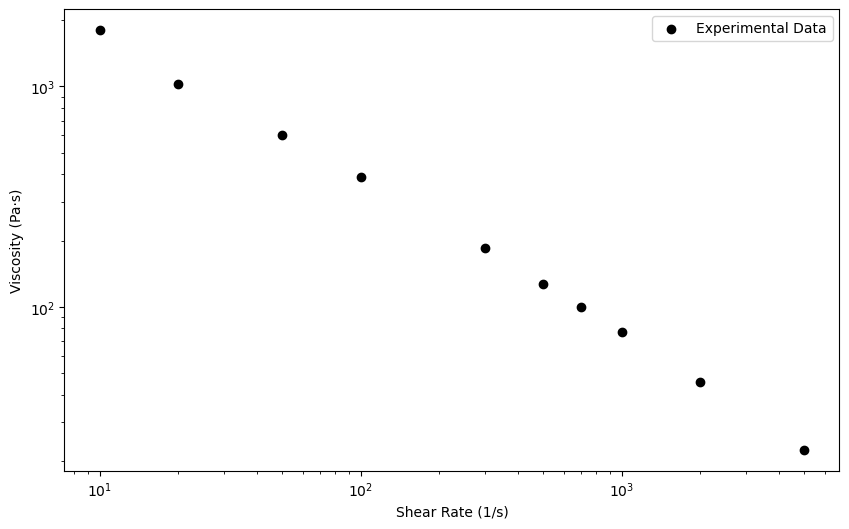

In [3]:
# extract numpy arrays from the dataframe columns
x1 = df_ares['Shear Rate'].values
y_stress = df_ares['Shear Stress'].values
y_visc = df_ares['Viscosity'].values

plt.figure(figsize=(10, 6))
plt.scatter(x1, y_visc, color='k', label='Experimental Data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Shear Rate (1/s)')
plt.ylabel('Viscosity (Pa·s)')
plt.legend()
plt.show()


## 2. Curve fitting functions

In [4]:
# Function to calculate the Ostwald de Waele (power law) model 
def power(x,  K, n):
    return K*x**(n-1)

# Function to calculate the Carreau model
# from https://en.wikipedia.org/wiki/Carreau_fluid
def Carreau(x, eta0, eta_inf, L, n):
    """Carreau model - avoids negative viscosity"""
    term = (L * x) ** 2
    return np.maximum(eta_inf, 0) + (eta0 - np.maximum(eta_inf, 0)) * (1 + term) ** ((n - 1) / 2)

def Yasuda(x, eta0, eta_inf, L, n, a):
    """Yasuda model - numerically safeguarded"""
    term = np.maximum((L * x) ** a, 1e-10)  # Prevents (negative)^fractional
    return np.maximum(eta_inf, 0) + (eta0 - np.maximum(eta_inf, 0)) * (1 + term) ** ((n - 1) / a)


In [5]:
def non_newtonian_fits(x, y):
    models = [power, Carreau, Yasuda]
    model_param_list = []
    
    # Initial parameter guesses (physically reasonable)
    eta0_guess = y[0]  # Initial viscosity (~14349 Pa.s)
    eta_inf_guess = y[-1]  # Final viscosity (~189 Pa.s)
    
    # Bounds for each model (prevents unphysical values)
    bounds = {
        power: ([0, 0], [np.inf, 1]),  # K > 0, 0 < n < 1
        Carreau: ([0, 0, 0, 0], [np.inf, np.inf, np.inf, 1]),  # eta0 > 0, 0 < n < 1
        Yasuda: ([0, 0, 0, 0, 0.1], [np.inf, np.inf, np.inf, 1, 10]),  # a > 0.1
    }
    
    # Initial parameter guesses for each model
    p0 = {
        power: [1e4, 0.5],  # K, n
        Carreau: [eta0_guess, eta_inf_guess, 1.0, 0.5],  # eta0, eta_inf, L, n
        Yasuda: [eta0_guess, eta_inf_guess, 1.0, 0.5, 2.0],  # + a
    }
    
    for model in models:
        try:
            params, _ = curve_fit(
                model, x, y, 
                p0=p0[model], 
                bounds=bounds[model],
                maxfev=5000
            )
            model_param_list.append(np.round(params, 4))
        except Exception as e:
            print(f"Fit failed for {model.__name__}: {e}")
            model_param_list.append(None)
    
    return model_param_list

# Run fitting
NonNewtonian_param_list = non_newtonian_fits(x1, y_visc)
NonNewtonian_param_list

[array([8.6339312e+03, 3.1210000e-01]),
 array([2.55898028e+05, 1.41137000e+01, 1.14048800e+02, 2.92800000e-01]),
 array([4.9950484e+03, 1.4113600e+01, 4.3460000e-01, 2.9280000e-01,
        1.0000000e+01])]

### 3. Compute viscosity values from each fit

In [6]:
# now let's calculate the viscosity values from the fit
eta_pow = NonNewtonian_param_list[0][0] * (x1**(NonNewtonian_param_list[0][1]-1))

# Carreau parameters

eta0 = NonNewtonian_param_list[1][0]
eta_inf = NonNewtonian_param_list[1][1]
L = NonNewtonian_param_list[1][2]
n = NonNewtonian_param_list[1][3]


eta_car = eta_inf + (eta0 - eta_inf)*(1 + (L*x1)**2)**((n-1)/2)

# Yasuda parameters
eta0 = NonNewtonian_param_list[2][0]
eta_inf = NonNewtonian_param_list[2][1]
L = NonNewtonian_param_list[2][2]
n = NonNewtonian_param_list[2][3]
a = NonNewtonian_param_list[2][4]

eta_yas = eta_inf + (eta0-eta_inf) * ((1 + (L*x1)**a)**((n-1)/a))


### 4. Models scores

In [7]:
def compare_models(eta_list):    
    MLA_names = []
    ExplVar_scores = [] # explained variance list
    MAE_scores = [] # mean average error list
    RMSE_scores = [] # root mean square error list
    R2_scores = [] # regression coefficients list
    MLA_names = ['Ostwald – de Waele power law', 'Carreau', 'Carreau-Yasuda', 'Cross', 'Bingham',"Herschel-Bulkley", 'Casson']
       
    for y_pred in eta_list:
                
        #model scores  
        R2 = r2_score(y_visc, y_pred)
        EV = explained_variance_score(y_visc, y_pred)
        MAE = mean_absolute_error(y_visc, y_pred)

        MSE = mean_squared_error(y_visc, y_pred)
        RMSE = np.sqrt(MSE)

        # add results to lists for a final comparison
               
        MAE_scores.append(round(MAE, 2))
        ExplVar_scores.append(round(EV, 2))
        RMSE_scores.append(round(RMSE, 2))
        R2_scores.append(round(R2, 4))
        
    
    #create table to compare MLA metrics
    MLA_columns = ['Model Name', 'Explained Variance','MAE', 'RMSE', 'R2']
    zippedList =  list(zip(MLA_names, ExplVar_scores, MAE_scores, RMSE_scores, R2_scores))
    df = pd.DataFrame(zippedList, columns = MLA_columns)#.sort_values(by=['R2'],ascending=False)
    return df

In [8]:
eta_list = [eta_pow, eta_car, eta_yas]
df_results = compare_models(eta_list)
list_power =['K','n']
list_carreau = ['eta0',  'eta_inf','L', 'n']
list_yasuda = ['eta0', 'eta_inf', 'L', 'n','a']


models_name_list = ['Ostwald – de Waele power law', 'Carreau', 'Carreau-Yasuda']
coefficient_list = [list_power, list_carreau, list_yasuda]

# After creating eta_list, use the same filtered dataframe
df_final = df_ares.copy()  # This ensures same number of rows

for i in range(len(models_name_list)):
    name = f"{models_name_list[i]}_viscosity"
    df_final[name] = eta_list[i]  # Now both should have the same length

df_final

,Shear Rate,Shear Stress,Viscosity,Ostwald – de Waele power law_viscosity,Carreau_viscosity,Carreau-Yasuda_viscosity
0,9.996588,18001.251666,1800.739514,1771.782975,1776.792215,1776.733193
1,20.005338,20632.517203,1031.350592,1099.386307,1093.303974,1093.267611
2,49.995103,30071.689232,601.492694,585.485816,578.773563,578.754457
3,100.002367,39009.660623,390.087371,363.413880,359.942499,359.930756
4,299.994941,55590.857389,185.305983,170.687576,173.134325,173.128871
5,499.999676,63735.271769,127.470626,120.112252,124.918109,124.914278
6,699.992250,70125.501368,100.180397,95.294744,101.454767,101.451727
7,999.999352,76849.895746,76.849946,74.560494,81.982259,81.979874
8,1999.986543,91133.921957,45.567268,46.284125,55.683897,55.682397
9,4999.972438,112309.390038,22.462002,24.642727,35.858656,35.857824


## 5. Output files

In [9]:
output_name = input("Enter output file name: ")
print(output_name)


Enter output file name:  PP_1.0NC


PP_1.0NC


In [10]:
#Prepare parameters table
l1 = NonNewtonian_param_list
parameters_values = [*l1]#.append()
param_zippedList =  list(zip(models_name_list, coefficient_list, parameters_values))
df_param = pd.DataFrame(param_zippedList, columns = ['model','coefficient','value'])
df_param

,model,coefficient,value
0,Ostwald – de Waele power law,"[K, n]","[8633.9312, 0.3121]"
1,Carreau,"[eta0, eta_inf, L, n]","[255898.028, 14.1137, 114.0488, 0.2928]"
2,Carreau-Yasuda,"[eta0, eta_inf, L, n, a]","[4995.0484, 14.1136, 0.4346, 0.2928, 10.0]"


In [11]:
df_results = pd.merge(df_param, df_results, left_on='model', right_on='Model Name')
df_results = df_results.drop(['Model Name'], axis=1)
df_results

,model,coefficient,value,Explained Variance,MAE,RMSE,R2
0,Ostwald – de Waele power law,"[K, n]","[8633.9312, 0.3121]",1.0,17.17,25.96,0.9977
1,Carreau,"[eta0, eta_inf, L, n]","[255898.028, 14.1137, 114.0488, 0.2928]",1.0,18.34,25.10,0.9979
2,Carreau-Yasuda,"[eta0, eta_inf, L, n, a]","[4995.0484, 14.1136, 0.4346, 0.2928, 10.0]",1.0,18.35,25.10,0.9979


In [12]:
with pd.ExcelWriter(f"{output_name}_capillary_output.xlsx", engine='openpyxl') as writer:
    df_final.to_excel(writer, sheet_name='Viscosity_Data', index=False)
    df_results.to_excel(writer, sheet_name='Model_Results', index=False)

Finally let's plot the results

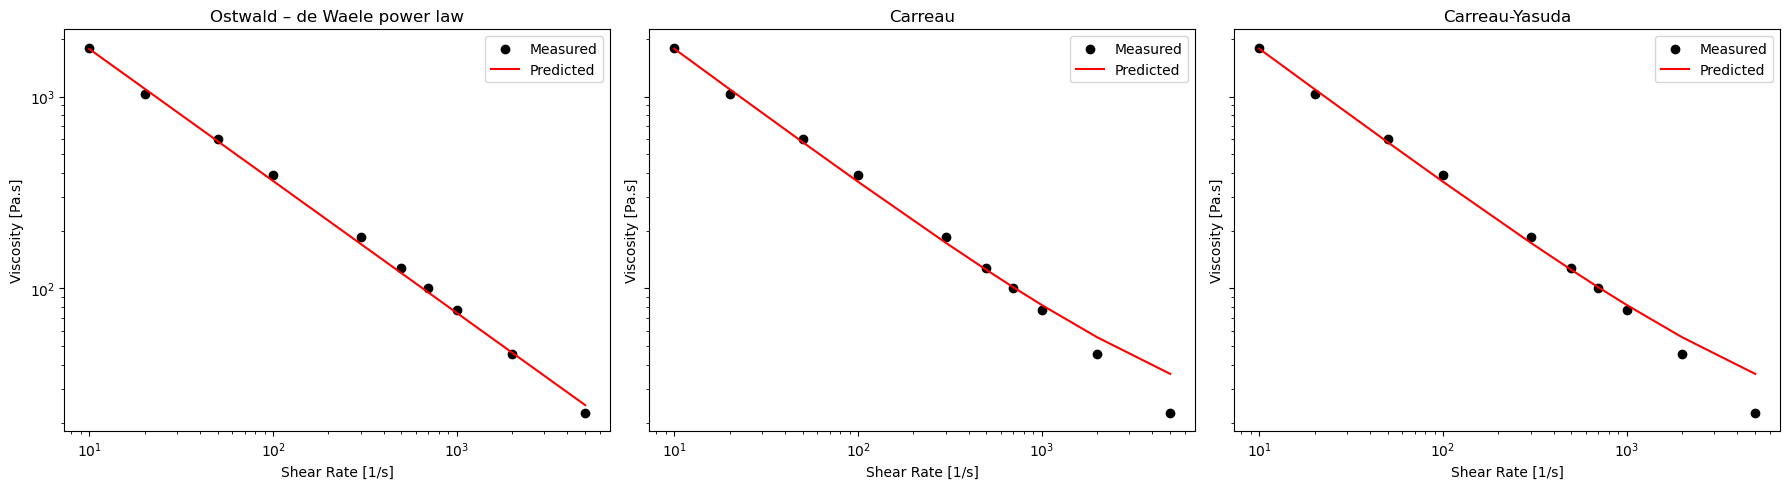

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)  # 1 row, 3 columns

for i, ax in enumerate(axes):
    ax.scatter(df_ares['Shear Rate'], df_ares['Viscosity'], color='k', label='Measured')
    ax.plot(x1, eta_list[i], color='r', label='Predicted')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(models_name_list[i])
    ax.set_xlabel('Shear Rate [1/s]')
    ax.set_ylabel('Viscosity [Pa.s]')
    ax.legend()

plt.tight_layout()
plt.show()